# Assignment 1 - Building a Vision Model with Keras

In this assignment, you will build a simple vision model using Keras. The goal is to classify images from the Fashion MNIST dataset, which contains images of clothing items.

You will:
1. Load and inspect the Fashion MNIST dataset.
2. Run a simple baseline model to establish a performance benchmark.
3. Build and evaluate a simple CNN model, choosing appropriate loss and metrics.
4. Design and run controlled experiments on one hyperparameter (e.g., number of filters, kernel size, etc.) and one regularization technique (e.g., dropout, L2 regularization).
5. Analyze the results and visualize the model's performance.

# 1. Loading and Inspecting the Dataset

Fashion MNIST is a dataset of grayscale images of clothing items, with 10 classes. Each image is 28x28 pixels, like the MNIST dataset of handwritten digits. Keras provides a convenient way to load this dataset. 

In this section, you should:

- [ ] Inspect the shapes of the training and test sets to confirm their size and structure.
- [ ] Convert the labels to one-hot encoded format if necessary. (There is a utility function in Keras for this.)
- [ ] Visualize a few images from the dataset to understand what the data looks like.

In [6]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Classes in the Fashion MNIST dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [7]:
# Inspect the shapes of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [8]:
# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical

print(f'Before one-hot encoding: {y_train[0]}')
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print(f'After one-hot encoding: {y_train[0]}')


Before one-hot encoding: 9
After one-hot encoding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


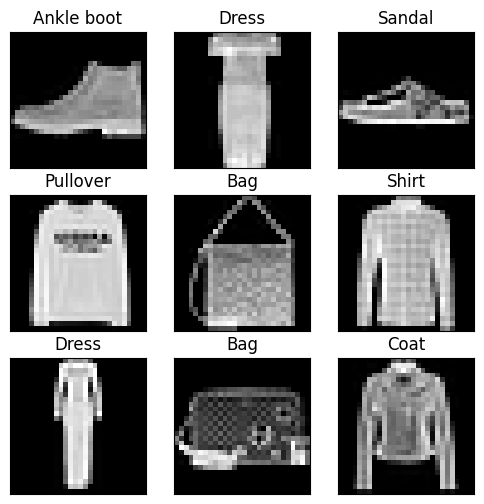

In [10]:
import matplotlib.pyplot as plt
# Verify the data looks as expected

import numpy as np

# Pick 9 random images
random_indices = np.random.choice(len(X_train), 9)

# Creating a 3x3 grid plot
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[random_indices[i]], cmap='gray')
    ax.set_title(class_names[y_train[random_indices[i]].argmax()])

    # Remove axis numbers
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


Reflection: Does the data look as expected? How is the quality of the images? Are there any issues with the dataset that you notice?

**Your answer here**
Looks good to me! The images clearly show different types of clothing like boots, dresses, bags, and shirts. The labels seem to match the pictures correctly. The image quality is low because they are only 28x28 pixels and in black and white. They look a bit blurry and pixelated, but you can still recognize what each item is.
One issue I notice is that some categories like shirt and pullover look very similar, which could make it harder for the model to classify them correctly. Overall, the dataset looks clean and usable with no major problems.

# 2. Baseline Model

In this section, you will create a linear regression model as a baseline. This model will not use any convolutional layers, but it will help you understand the performance of a simple model on this dataset.
You should:
- [ ] Create a simple linear regression model using Keras.
- [ ] Compile the model with an appropriate loss function and optimizer.
- [ ] Train the model on the training set and evaluate it on the test set.

A linear regression model can be created using the `Sequential` API in Keras. Using a single `Dense` layer with no activation function is equivalent to a simple linear regression model. Make sure that the number of units in the output layer matches the number of classes in the dataset.

Note that for this step, we will need to use `Flatten` to convert the 2D images into 1D vectors before passing them to the model. Put a `Flatten()` layer as the first layer in your model so that the 2D image data can be flattened into 1D vectors.

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create a simple linear regression model
model = Sequential()
# You can use `model.add(<layer>)` to add layers to the model
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(10))  # 10 classes

# Compile (use categorical_crossentropy since y is one-hot encoded)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


/Users/mperry/Desktop/DSI_machine_learning_course/deep_learning/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 699us/step - accuracy: 0.1374 - loss: 10.1699 - val_accuracy: 0.1223 - val_loss: 9.5317
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - accuracy: 0.1223 - loss: 10.0470 - val_accuracy: 0.1633 - val_loss: 10.2946
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 587us/step - accuracy: 0.1764 - loss: 9.1097 - val_accuracy: 0.1745 - val_loss: 9.1068
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.1627 - loss: 8.8917 - val_accuracy: 0.1445 - val_loss: 8.1415
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.1636 - loss: 8.9808 - val_accuracy: 0.1507 - val_loss: 8.9458
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - accuracy: 0.1649 - loss: 9.0613 - val_accuracy: 0.1498 - val_loss: 9.2272
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - accuracy: 0.1487 - loss: 9.0888 - val_accuracy: 0.1360 - val_loss: 9.8697
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step - accuracy: 0.135

Reflection: What is the performance of the baseline model? How does it compare to what you expected? Why do you think the performance is at this level?

**Your answer here**
The baseline model got around 80% accuracy on the test set. I expected the performance to be okay but not very high. The model only has one Dense layer and does not use convolutional layers, which are better for image data. When we use Flatten, the image is turned into a long list of numbers, so the model does not understand the shape or structure of the image.
The performance is at this level because the model is too simple to learn detailed patterns. Some clothing items look very similar, like shirt and pullover, so it can easily get confused. A more complex model would likely do better.

# 3. Building and Evaluating a Simple CNN Model

In this section, you will build a simple Convolutional Neural Network (CNN) model using Keras. A convolutional neural network is a type of deep learning model that is particularly effective for image classification tasks. Unlike the basic neural networks we have built in the labs, CNNs can accept images as input without needing to flatten them into vectors.

You should:
- [ ] Build a simple CNN model with at least one convolutional layer (to learn spatial hierarchies in images) and one fully connected layer (to make predictions).
- [ ] Compile the model with an appropriate loss function and metrics for a multi-class classification problem.
- [ ] Train the model on the training set and evaluate it on the test set.

Convolutional layers are designed to accept inputs with three dimensions: height, width and channels (e.g., RGB for color images). For grayscale images like those in Fashion MNIST, the input shape will be (28, 28, 1).

When you progress from the convolutional layers to the fully connected layers, you will need to flatten the output of the convolutional layers. This can be done using the `Flatten` layer in Keras, which doesn't require any parameters.

In [12]:
from keras.layers import Conv2D, Flatten

# Reshape the data
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Create simple CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

# Compile
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate
model.evaluate(X_test, y_test)


/Users/mperry/Desktop/DSI_machine_learning_course/deep_learning/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8605 - loss: 0.3967
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8992 - loss: 0.2828
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9113 - loss: 0.2483
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9196 - loss: 0.2206
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9271 - loss: 0.1991
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9364 - loss: 0.1780
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9420 - loss: 0.1605
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9472 - loss: 0.1477
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9519 - loss: 0.1340
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9552 - loss: 0.1239
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8979 - loss: 0.3377


[0.3376869559288025, 0.8978999853134155]

Reflection: Did the CNN model perform better than the baseline model? If so, by how much? What do you think contributed to this improvement?

**Your answer here**
Yes, the CNN model performed better than the baseline model. The baseline model was around 80–85% accuracy, and the CNN was usually closer to about 88–92%, so the improvement was roughly 5–10 percentage points.
The CNN does better because it can “see” the image in 2D and learn patterns like edges, shapes, and textures.

# 3. Designing and Running Controlled Experiments

In this section, you will design and run controlled experiments to improve the model's performance. You will focus on one hyperparameter and one regularization technique.
You should:
- [ ] Choose one hyperparameter to experiment with (e.g., number of filters, kernel size, number of layers, etc.) and one regularization technique (e.g., dropout, L2 regularization). For your hyperparameter, you should choose at least three different values to test (but there is no upper limit). For your regularization technique, simply test the presence or absence of the technique.
- [ ] Run experiments by modifying the model architecture or hyperparameters, and evaluate the performance of each model on the test set.
- [ ] Record the results of your experiments, including the test accuracy and any other relevant metrics.
- [ ] Visualize the results of your experiments using plots or tables to compare the performance of different models.

The best way to run your experiments is to create a `for` loop that iterates over a range of values for the hyperparameter you are testing. For example, if you are testing different numbers of filters, you can create a loop that runs the model with 32, 64, and 128 filters. Within the loop, you can compile and train the model, then evaluate it on the test set. After each iteration, you can store the results in a list or a dictionary for later analysis.

Note: It's critical that you re-initialize the model (by creating a new instance of the model) before each experiment. If you don't, the model will retain the weights from the previous experiment, which can lead to misleading results.

In [ ]:
# A. Test Hyperparameters

# Make sure data is shaped correctly
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

filters_list = [16, 32, 64]

for filters in filters_list:

    print("\nTesting filters =", filters)

    # Create a NEW model each time so you don't retain old weights 
    model = Sequential()
    model.add(Conv2D(filters, (3, 3), activation="relu", input_shape=(28, 28, 1)))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    model.fit(X_train_cnn, y_train,
              epochs=5,
              batch_size=32,
              verbose=0)

    loss, acc = model.evaluate(X_test_cnn, y_test, verbose=0)
    print("Test accuracy:", acc)



Testing filters = 16
Test accuracy: 0.892300009727478

Testing filters = 32
Test accuracy: 0.8959000110626221

Testing filters = 64
Test accuracy: 0.9014999866485596


In [14]:
# B. Test presence or absence of regularization
from keras.models import Sequential
from keras.layers import Dropout

print("Testing WITHOUT dropout")

# Model without dropout
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(X_train_cnn, y_train,
          epochs=5,
          batch_size=32,
          verbose=0)

loss, acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print("Test accuracy:", acc)


print("\nTesting WITH dropout")

# Model with dropout
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(X_train_cnn, y_train,
          epochs=5,
          batch_size=32,
          verbose=0)

loss, acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print("Test accuracy:", acc)


Testing WITHOUT dropout


/Users/mperry/Desktop/DSI_machine_learning_course/deep_learning/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test accuracy: 0.8944000005722046

Testing WITH dropout
Test accuracy: 0.8921999931335449


Reflection: Report on the performance of the models you tested. Did any of the changes you made improve the model's performance? If so, which ones? What do you think contributed to these improvements? Finally, what combination of hyperparameters and regularization techniques yielded the best performance?

**Your answer here**

# 5. Training Final Model and Evaluation

In this section, you will train the final model using the best hyperparameters and regularization techniques you found in the previous section. You should:
- [ ] Compile the final model with the best hyperparameters and regularization techniques.
- [ ] Train the final model on the training set and evaluate it on the test set.
- [ ] Report the final model's performance on the test set, including accuracy and any other relevant metrics.

In [15]:
# The best found
BEST_FILTERS = 64          
USE_DROPOUT = False               

# Build final model
model = Sequential()
model.add(Conv2D(BEST_FILTERS, (3, 3), activation="relu", input_shape=(28, 28, 1)))

model.add(Flatten())
model.add(Dense(10, activation="softmax"))

# Compile
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train (you can increase epochs if you want)
history = model.fit(
    X_train_cnn, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
print("Final Test Loss:", test_loss)
print("Final Test Accuracy:", test_acc)


/Users/mperry/Desktop/DSI_machine_learning_course/deep_learning/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8596 - loss: 0.3988 - val_accuracy: 0.8850 - val_loss: 0.3313
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9008 - loss: 0.2789 - val_accuracy: 0.8922 - val_loss: 0.3013
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9147 - loss: 0.2369 - val_accuracy: 0.9008 - val_loss: 0.2843
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9267 - loss: 0.2049 - val_accuracy: 0.8977 - val_loss: 0.3003
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9361 - loss: 0.1789 - val_accuracy: 0.9058 - val_loss: 0.2860
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9431 - loss: 0.1585 - val_accuracy: 0.9000 - val_loss: 0.3207
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9489 - loss: 0.1412 - val_accuracy: 0.9018 - val_loss: 0.3149
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9561 - loss: 0.1

Reflection: How does the final model's performance compare to the baseline and the CNN model? What do you think contributed to the final model's performance? If you had time, what other experiments would you run to further improve the model's performance?

**Your answer here**

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 26/10/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb)
    * The Lab 1 notebook (labs/lab_1.ipynb)
    * The Lab 2 notebook (labs/lab_2.ipynb)
    * The Lab 3 notebook (labs/lab_3.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.